In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [14]:
# %config InlineBackend.figure_format = 'retina'
# from qbstyles import mpl_style
# mpl_style(dark=True)

plt.style.use("dark_background")

In [15]:
# Load the CSV file
# whitelist = ["vega", "haruspex", "stalker", "fizz", "crackle", "pop", "dagger"]
whitelist = ["lambda"]
# whitelist = ["stalker"]
PATH = "../../bullet/checkpoints"

dfs: list[tuple[str, pd.DataFrame]] = []
for file in sorted(os.listdir(PATH)):
    if not any(name in file for name in whitelist):
        continue
    file_path = f"{PATH}/{file}/log.txt"
    print(f"{file_path = }")

    df = pd.read_csv(  # type: ignore
        file_path, header=None, names=["superbatch", "batch", "loss"], dtype=str
    )  

    assert isinstance(df, pd.DataFrame)

    print(f"lines = {len(df)}")

    # print(df.head())
    df["superbatch"] = df["superbatch"].str.removeprefix("superbatch:").astype(int)
    df["batch"] = df["batch"].str.removeprefix("batch:").astype(int)
    df["loss"] = df["loss"].str.removeprefix("loss:").astype(float)
    # print(df.head())

    # Group by epoch and calculate the average loss for each epoch
    df["total_batch"] = (df["superbatch"] - 1) * 6104 + df["batch"]
    df.drop(["superbatch", "batch"], axis=1, inplace=True)

    for i in range(1,len(df["loss"])-1):
        if i % (6104 // 32) == 0:
            df.loc[i, 'loss'] = df.loc[i - 1, 'loss']

    dfs.append((file, df))

file_path = '../../bullet/checkpoints/lambda-0.0-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.1-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.2-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.3-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.4-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.5-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.6-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.7-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.8-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-0.9-800/log.txt'
lines = 152000
file_path = '../../bullet/checkpoints/lambda-1.0-800/log.txt'
lines = 152000


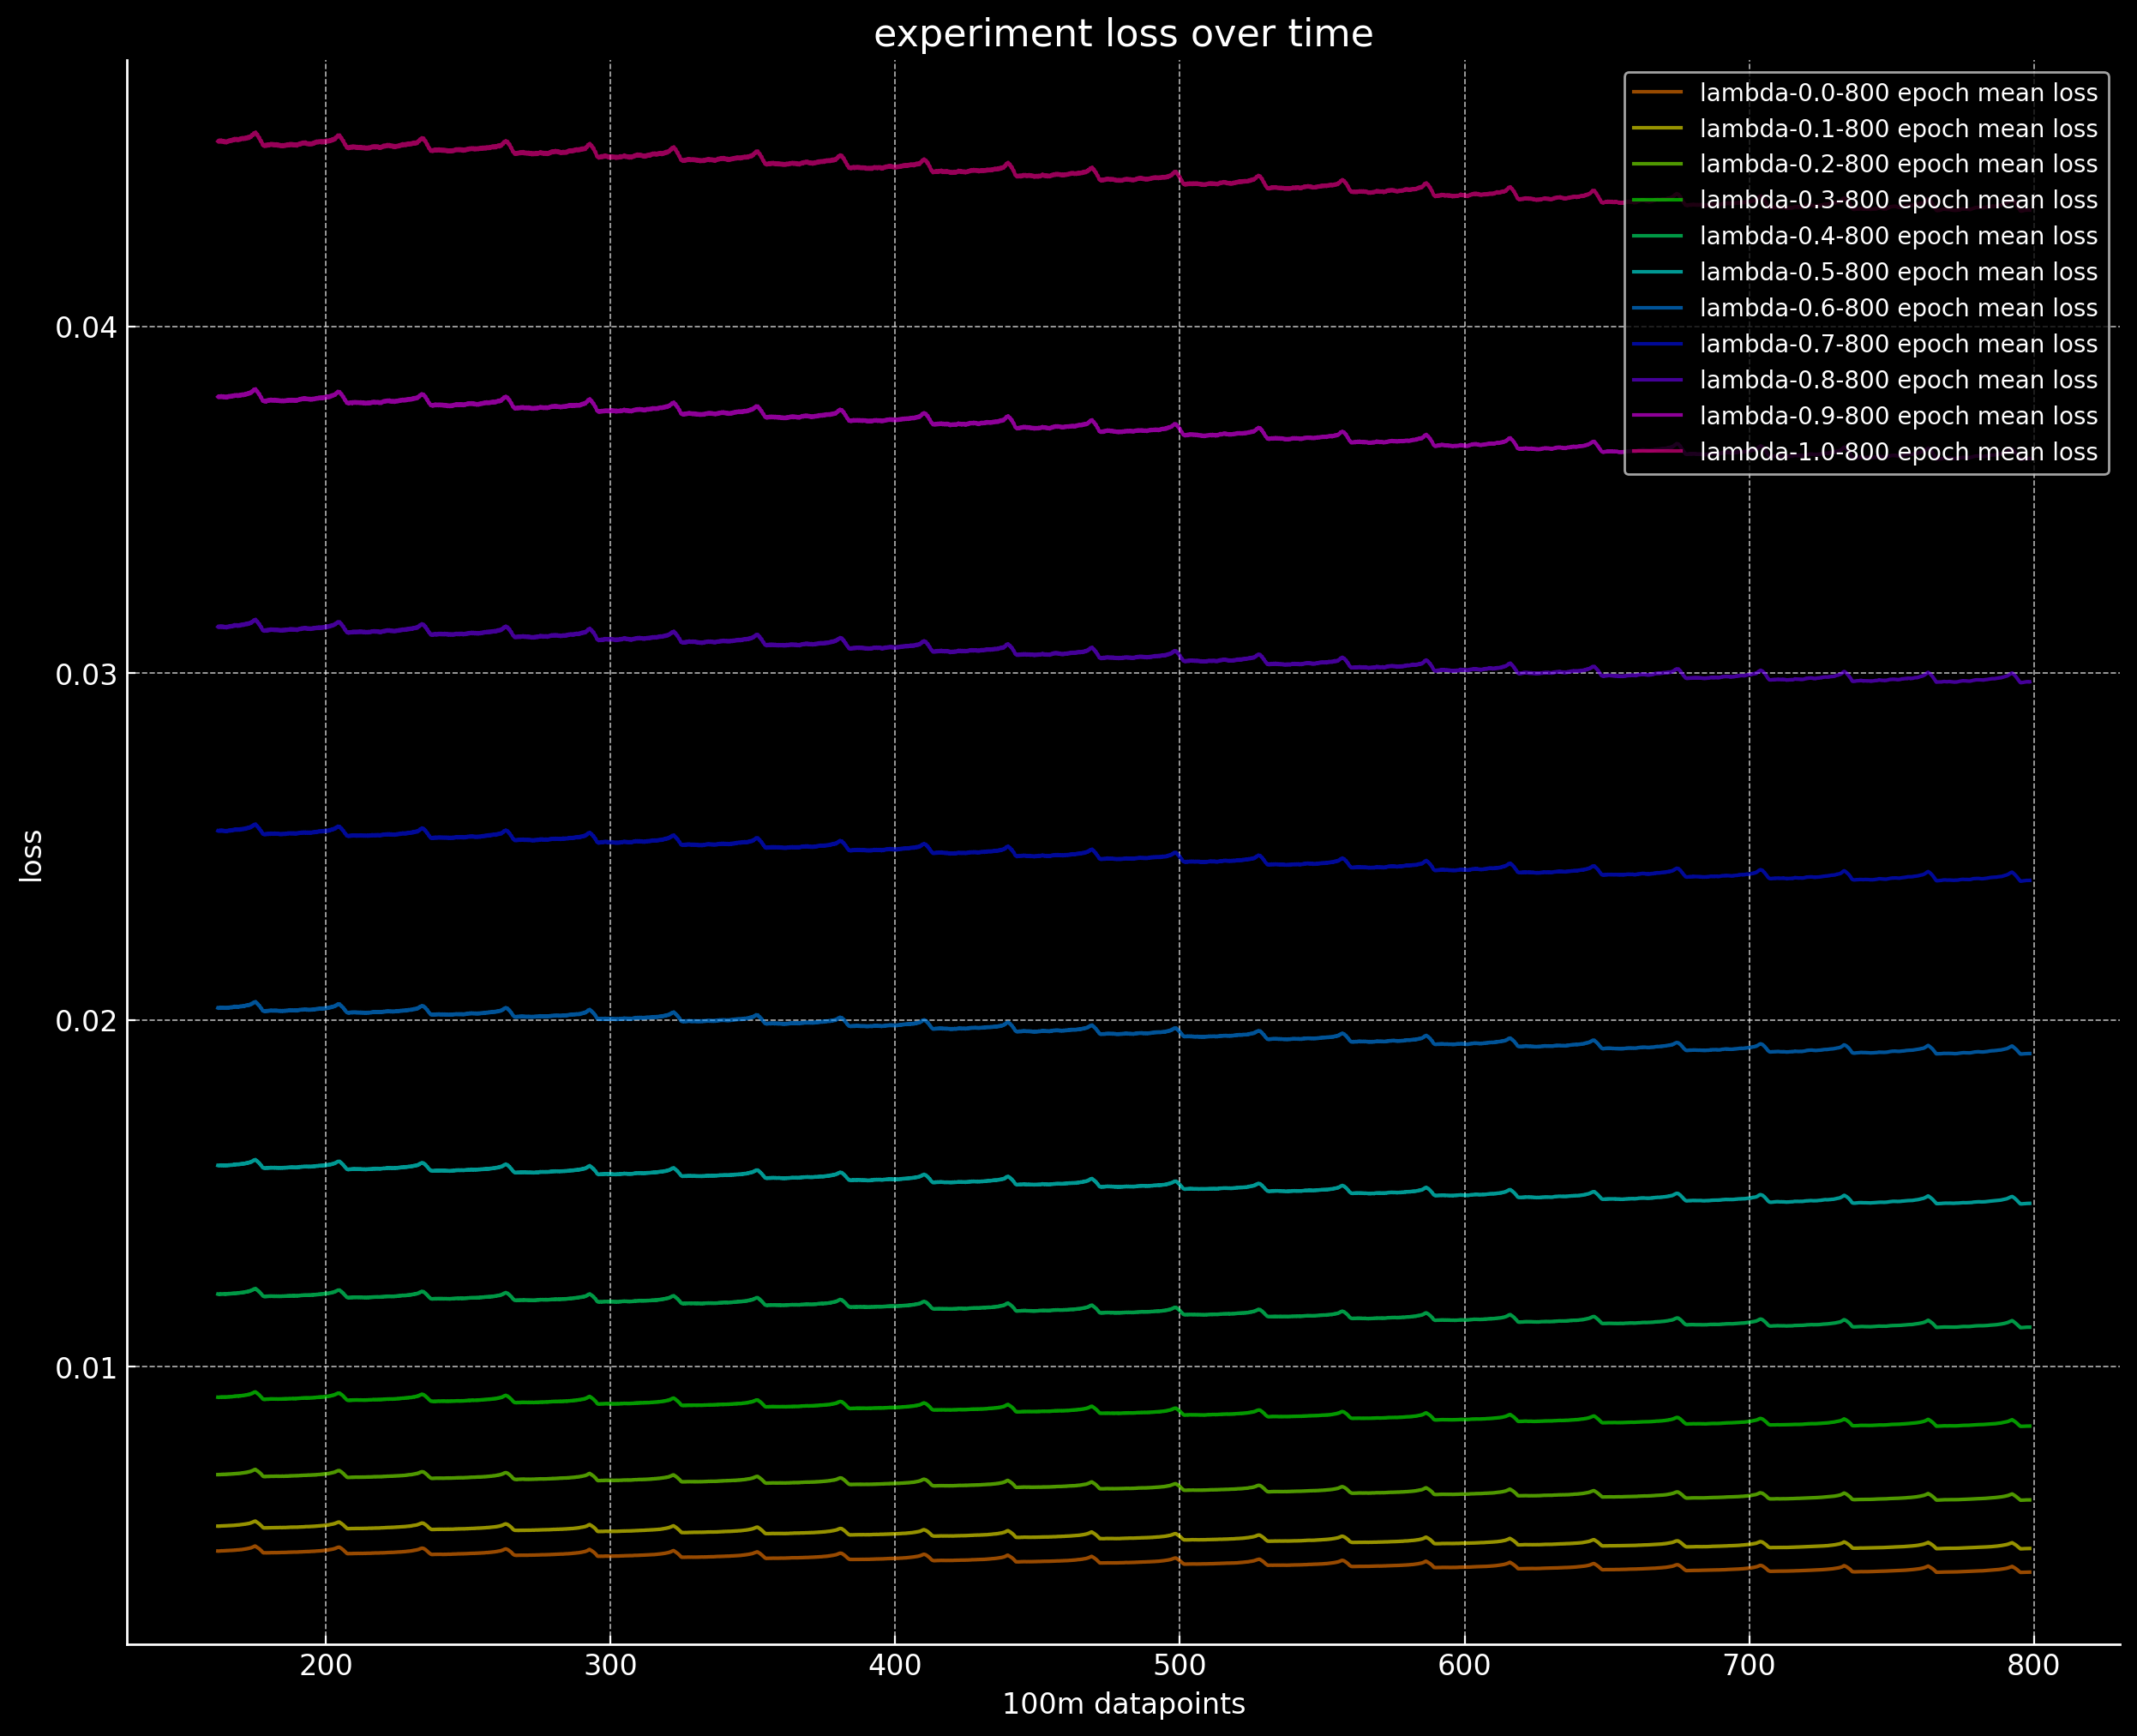

In [16]:
# Plotting
plt.figure(figsize=(15, 12)) # type: ignore

CONV = 551
HALF = (CONV - 1) // 2

# colors = ["coral", "cyan", "orange", "red", "green", "blue", "pink", "white"]
# colors = ["red", "blue", "orange", "green"]

# for lots of colours, use a gradient:
colors = sns.color_palette("hsv", len(dfs))

colors = (c for c in colors)

for file, df in dfs:
    df = df[30000:]
    x = df["total_batch"][500:][HALF:-HALF] / 6104
    y = np.convolve(df["loss"][500:], np.ones(CONV) / CONV, "valid")
    plt.plot(  # type: ignore
        x,
        y,
        label=f"{file} epoch mean loss",
        alpha=0.6,
        color=next(colors),
    )

# Adding labels and title
plt.xlabel("100m datapoints") # type: ignore
plt.ylabel('loss') # type: ignore
plt.title('experiment loss over time') # type: ignore
plt.legend() # type: ignore
plt.grid(True) # type: ignore

# Show the plot
plt.show() # type: ignore